In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Metric box classifier: evaluation metrics

**25.08.2020**

It's important to have a measure of how well a classifier performs, and given the data, there are a few metrics which can be used to measure this.

**NOTE: this is based on an earlier version of the metrics, pre 09.11.2020**

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator

import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [4]:
from synthetic_data.plotting import plot_trajectory, add_plot_trajectory, add_plot_seg_boxes, add_plot_cluster_boxplots

In [5]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays

# Theory

## Standard metrics

There are a few standard metrics which can be used for classification problems. Here, we use the precision and recall as well as the error (aka the accuracy).

For all metrics, there are a few things to consider.
1. The sequence of events is not simply classified as independent events; the clusters of events also matter
2. Since the clusters matter, the correct number of segments also matters
3. However, there is (or may be) a propensity towards false positive stays but which (may) have a small impact.

Therefore, we apply the metrics to the entire sequence and also on the segments of the sequence.

### Precision and Recall
 
A brief review of the definitions:

Let the total number of stay (travel) events be $N_s$ ($N_t$) and the corresponding incorrect counts denoted as $\tilde{N}_{\{\}}$. 
* $\mathrm{prec.} = {N_s}/(N_s + \tilde{N}_s)$, the number of correctly classified stay-events over the total number classified stay events.
    * this is sensitive the the number of false positives
* $\mathrm{rec.} = {N_s}/(N_s + \tilde{N}_t)$, the number of correctly classified stay-events over the total number stay events.
    * it is not uncommon for the recall to be 1.0; this is due to classified stays being larger than the true stays.  
      If the middle $3^{\mathrm{rd}}$ of a trajectory is a true stay, but the entire trajectory is classified as a stay,  
      there are no incorrectly classified trip events (_ie_ no false negatives), and hence the recall is 1.0

### Error fraction (and/or Accuracy)

The error is given effectively by treating the arrays of labels as vectors of 1's (stays) and 0's (travels) and then computing 

$\varepsilon = |\mathbf{v}_{\mathrm{true}} - \mathbf{v}_{\mathrm{pred}}|/\mathrm{size}(\mathbf{v}_{\mathrm{true}})$. 

This is related to the accuracy by 

$\mathrm{acc.} = 1 - \varepsilon$, 

which is the same as 

$\mathrm{acc.} = \big((N_t + \tilde{N}_s + \tilde{N}_t + N_s) - (\tilde{N}_s + \tilde{N}_t)\big)/(N_t + \tilde{N}_s + \tilde{N}_t + N_s)$

One of the problems with the accuracy in this setting is that there is usually more stay events than travel events; making accuracy skewed towards larger values.  
Also, the number of events can be fairly large, so that mis-classified events don't contribute significantly to the global scores.  

For example, an event evey 1 min of a 24 hr day is 1440 events; estimating 2 hrs (120 events) in total travel time, leaves 1320 events to classify as stay events.  
If 100% of the stay events are correctly classified, but only 1% of the travel events are correct (meaning false positives or incorrectly classified stay events),  
then the accuracy would still be above 0.91.

In [143]:
(1.0*1320 + 0.01*120)/1440

0.9175

---

# Illustrations

Here is a bit more theory but fleshed out with some examples

## Example 1

In [12]:
from synthetic_data.trajectory_class import get_pickle_trajectory
from stay_classification.metric_box_classifier.metric_box_classifier import stay_classifier_testing

time_thresh = 1/6
dist_thresh=0.25

In [13]:
data_dir = f"../../testdata/testdata_training_set__canonical_3stays/"
stays_tag = 3

### Classification

Load data

In [14]:
trajectory_nr = 445 #488 #958 #445

trajectory_tag = f"trajectory{trajectory_nr}_{stays_tag}stays"    
path_to_file =  data_dir + trajectory_tag

In [15]:
t_arr, r_arr, x_arr, segments = get_pickle_trajectory(path_to_file)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, t_arr))

Classification

In [16]:
# Get the stay clusters
all_clusters = stay_classifier_testing(t_arr, x_arr, dist_thresh, time_thresh, False)    

Plotting

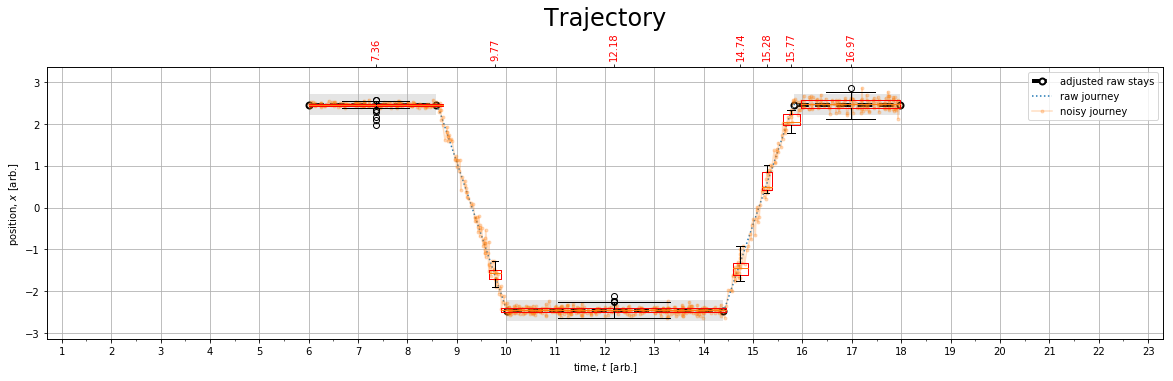

In [17]:
fig, ax = plt.subplots(1,1,figsize=[20,5])

ylim = [x_arr.min()-2*dist_thresh, x_arr.max()+2*dist_thresh]

add_plot_trajectory(t_arr, r_arr, x_arr, t_segs, x_segs, dist_thresh, ax)
ax.set_xlim(0.7,23.3)
add_plot_seg_boxes(t_segs, x_segs, dist_thresh, ax)
add_plot_cluster_boxplots(t_arr, x_arr, all_clusters[-1], dist_thresh, ax)
ax.set_ylim(ylim);
#ax.set_title(f"{stage_titels[-1]}", fontsize=16);

**Notes**
* There are three stays, all of which are mostly correctly identified by the classifier
* There are a few false stays (_ie_ false positives) during the main travels but these are all mostly short in duration

#### Prec & Rec

#### Total Precision and Recall

The first is to consider the entire sequence of points which are classified as either "stay" (1) or "travel" (0).
    
Again, the definitions of the (p)rec. scores:
* $\mathrm{prec.} = {N_s}/(N_s + \tilde{N}_s)$
* $\mathrm{rec.} = {N_s}/(N_s + \tilde{N}_t)$
    * **Note** if all events are classified as a stay, then $\tilde{N}_t = 0$, and recall is unity.

In [36]:
from stay_classification.metrics import get_segments_scores, print_p_and_r

In [ ]:
from stay_classification.metrics_scores import get_segments_scores_core

In [33]:
from stay_classification.metrics_etc import eval_synth_data, eval_synth_data_clusters_long

In [39]:
prec, rec, cmat = eval_synth_data(t_arr, segments, all_clusters[-1])
print_p_and_r(all_clusters[-1], prec, rec, cmat)

    7 clusters, lengths:, [184, 19, 328, 28, 17, 18, 131]
	prec.: 0.861
	 rec.: 1.000
[[ 87 102]
 [  0 633]]


The confusion matrix is also given, but as usual, it is confusing

$\left[\begin{array}[cc]\\ N_t & \tilde{N}_s\\ \tilde{N}_t & N_s \end{array}\right] = \left[\begin{array}[cc]\\ 87 & 102\\ 0 & 633 \end{array}\right]$

Let's break it down:
* $N_t $ is the number of correctly identified travel events
    * there are overall 189 true travel events but the classifier only gets 87 of those correct
* $\tilde{N}_s$ is the number of false stay events (mis-labeled travel events)
    * there are 102 of these
* $\tilde{N}_t$ is the number of false travel events (mis-labeled stay events)
    * here, the classifier gets 0, which is common given the spatial constraints of the synthetic data and the spatial resolution of the classifier
* $N_s$ is the number of correctly identified stay events
    * for this example, all the true stay events are identified by the classifier.

#### Segment-based Precision and Recall

The total (p)rec. scores above are not specific enough since there no indication if the total number of stays is correct or not.
* As an example, consider two adjacent predicted stays which match with a true stay; 
    using only the labels misses the fact that there are two predicted stays when there should only be one.

A way to measure this is to generalize these score to the predicted segments, _ie_ to the stays and travels. 

Let the number of stay (travel) events in segment $i$ be $n_{s,i}$($n_{t,i}$) and $\tilde{n}_{\{\}}$ (as above). 
The the scores are given as 
* $\mathrm{prec.}_i = n_{s,i}/(n_{s,i} + \tilde{n}_{s,i})$
* $\mathrm{rec.}_i = n_{s,i}/(n_{s,i} + \tilde{n}_{t,i})$

To get an overall measure, the segment scores are weighted by the event counts or duration of the cluster and then summed over.  
For each segment $s_i$,
1. check it against the true stays to see if there are any overlaps, and compute the scores
    1. if so, compute (p)rec.s for all overlapping sections
        * when a pred. segment overlaps multiple true segments, the average of the scores is used
        * Since the pred./true stay segments can be any size, they are first embedded into the entire sequence (see the methods below).
    2. if not, then assign (p)rec.s as $0$ for the segment
2. compute the total duration of the segment and multiply the segment score by a weight
    * Normalize by the total sum of pred. durations. 
    * this helps minimize the false positives which are short
3. compute the average, and/or the weighted average, over all pred. stays

This is made for both sets of clusters, ensuring that any non-overlapping clusters, 
from either true or predicted cluster sets, contribute to the overall scores.

In [116]:
from stay_classification.metrics_cluster_tools import get_true_clusters

In [117]:
true_clusters = get_true_clusters(t_arr, segments)

Here, `get_segments_scores(t_arr, segments, all_clusters[-1], True)` comprises of two subroutines:
1. get_segments_scores_core(t_arr, true_clusters, all_clusters[-1], True, True)

In [119]:
get_segments_scores_core(t_arr, true_clusters, all_clusters[-1], True, True);

Comparing 7 pred to 3 true clusters

Cluster   0: [   0, 183];  count:  184,  dur:  2.713
                          (frac. 0.254) (frac. 0.261)

             [   0, 175], overlap
             [ 272, 591]
             [ 685, 821]

	Overlaps with 1 true cluster(s):
          0: [   0, 175]; prec.:  0.957; rec.:  1.000

Cluster   1: [ 244, 264];  count:   19,  dur:  0.230
                          (frac. 0.026) (frac. 0.022)

             [   0, 175]
             [ 272, 591]
             [ 685, 821]

	No overlap
	                    prec.:  0.000; rec.:  0.000

Cluster   2: [ 266, 593];  count:  328,  dur:  4.554
                          (frac. 0.452) (frac. 0.439)

             [   0, 175]
             [ 272, 591], overlap
             [ 685, 821]

	Overlaps with 1 true cluster(s):
          1: [ 272, 591]; prec.:  0.976; rec.:  1.000

Cluster   3: [ 597, 624];  count:   28,  dur:  0.321
                          (frac. 0.039) (frac. 0.031)

             [   0, 175]
             [ 272, 

**Notes** 
* The three main stays are found by the classifier, each with $\mathrm{(p)rec} > 0.95$
* The avg. scores are relatively low because there are three false stays and one misalinged stay
    * however, these are relatively short in duration
* Both the count-weighted avg. (as "`c-avg.`") and the time-weighted avg. (as "`t-avg.`"),  
    show different information:
    * the prec. is higher than the global prec. ($0.861$) but the rec. is lower than $1.0$, which reflects the inclusion of incorrect clusters.

In [121]:
get_segments_scores_core(t_arr, all_clusters[-1], true_clusters, False, True);

Comparing 3 true to 7 pred clusters

Cluster   0: [   0, 175];  count:  176,  dur:  2.566
                          (frac. 0.278) (frac. 0.282)

             [   0, 183], overlap
             [ 244, 264]
             [ 266, 593]
             [ 597, 624]
             [ 636, 654]
             [ 667, 690]
             [ 691, 821]

	Overlaps with 1 pred cluster(s):
          0: [   0, 183]; prec.:  0.957; rec.:  1.000

Cluster   1: [ 272, 591];  count:  320,  dur:  4.381
                          (frac. 0.506) (frac. 0.481)

             [   0, 183]
             [ 244, 264]
             [ 266, 593], overlap
             [ 597, 624]
             [ 636, 654]
             [ 667, 690]
             [ 691, 821]

	Overlaps with 1 pred cluster(s):
          2: [ 266, 593]; prec.:  0.976; rec.:  1.000

Cluster   2: [ 685, 821];  count:  137,  dur:  2.159
                          (frac. 0.216) (frac. 0.237)

             [   0, 183]
             [ 244, 264]
             [ 266, 593]
             [ 5

Note that the scores for the overlapped clusters are equivalent in both runs,  but the weighting and the non-overlapping clusters affect the final scores. 

For example, the combined count weight of the scores in the first set is 0.91, whereas the same for the second set is 1.0; the partial results of the former is slightly smaller.


The final result of `get_segments_scores(t_arr, segments, all_clusters[-1], True)` outputs the two previous results,  
and then takes their mean for a final result:
```
Overall stats: 
    min. prec.:  0.312;    min. rec.:  0.250
  c-avg. prec.:  0.884;  c-avg. rec.:  0.884
  t-avg. prec.:  0.884;  t-avg. rec.:  0.884

    tot. prec.:  0.861;    tot. rec.:  1.000

Durations: 
	tot. trajectory duration: 11.973 
	tot. true stays duration:  9.106 (0.761) 
	tot. pred stays duration: 10.376 (0.867)
```

### Error

#### Total error

In [148]:
from stay_classification.metrics_cluster_tools import get_pred_labels, get_labels_from_clusters

In [149]:
from synthetic_data.trajectory import get_stay_indices, get_adjusted_stays

In [150]:
true_indices = get_stay_indices(get_adjusted_stays(segments, t_arr), t_arr)
true_labels = np.zeros(t_arr.shape)

for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

pred_labels = get_pred_labels(all_clusters[-1], t_arr.shape)

In [151]:
err__labels = abs(true_labels-pred_labels)
err__labels[err__labels == 0] = np.nan

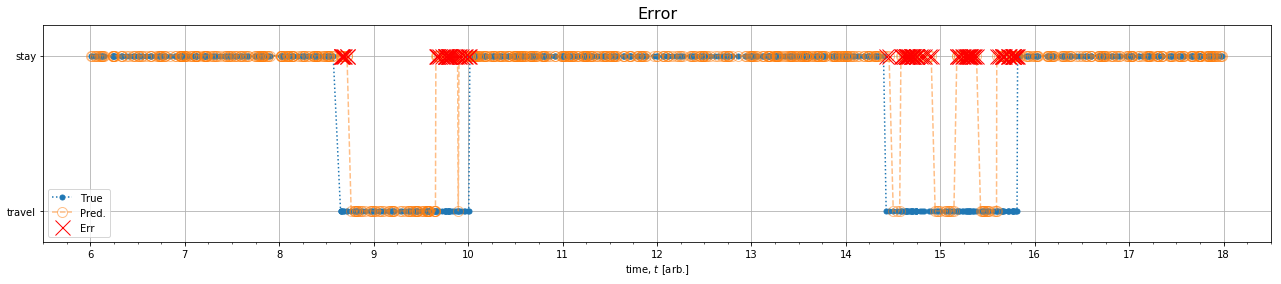

In [152]:
fig, ax = plt.subplots(1,1,figsize=(22,4))

plt.plot(t_arr, true_labels, '.:', markersize=10, label='True')
plt.plot(t_arr, pred_labels, 'o--', markerfacecolor="None", markersize=10, label='Pred.', alpha=0.5)
plt.plot(t_arr, err__labels, 'rx', markersize=15, label='Err')
plt.ylim(-0.2,1.2)
plt.xlim(5.5,18.5)

ax = plt.gca()

ax.xaxis.set_major_locator(MultipleLocator(1))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

plt.xlabel(r'time, $t$ [arb.]')

ax.set_yticks([0,1])
ax.set_yticklabels(['travel', 'stay'])
ax.set_title('Error', fontsize=16)

plt.legend()
plt.grid();

In [153]:
get_err = lambda trues, preds: np.sum(abs(trues-preds))/trues.size

In [154]:
for clusters in all_clusters:
    
    pred_labels = get_pred_labels(clusters, t_arr.shape)
    
    print(f"Error: {get_err(true_labels,pred_labels):5.3} (Acc.: {(1-get_err(true_labels,pred_labels)):5.3})")

Error:  0.22 (Acc.:  0.78)
Error: 0.201 (Acc.: 0.799)
Error: 0.201 (Acc.: 0.799)
Error: 0.201 (Acc.: 0.799)
Error: 0.124 (Acc.: 0.876)


#### Segment-based error

The total error (also accuracy) can be divided among the segments in the same way as the (p)rec. scores above. 

Again, tet the number of stay (travel) events in segment $i$ be $n_{s,i}$($n_{t,i}$) and $\tilde{n}_{\{\}}$ (as above). 
Then, the segment error is  
* $\varepsilon_i \propto \tilde{n}_{t,i} + \tilde{n}_{s,i}$

As above, the segment errors are weighted by either the event counts or the cluster duration and then summed over.  
When the latter is used, then for each segment $s_i$,
1. check it against the true stays to see if there are any overlaps, and compute the segment error
    1. if so, compute (p)rec.s for all overlapping sections
        * Since the pred./true stay segments can be any size, they are first embedded into the entire sequence.
        * when a pred. segment overlaps multiple true segments, 
            * the average of the error is used since the true segment is counted multiple times        
    2. if not, then compute the error of the pred. stay against nothing
2. Use the duration-weighting as above
3. compute the average, and/or the weighted average, over all pred. stays
    
Again, this is made for both sets of clusters, ensuring that any non-overlapping clusters, 
from either true or predicted cluster sets, contribute to the overall scores.

In [155]:
from stay_classification.metrics import get_segments_errs
from stay_classification.metrics_errors import get_segments_errs_core
from stay_classification.metrics_cluster_tools import get_true_clusters

In [156]:
true_clusters = get_true_clusters(t_arr, segments)

In [157]:
get_segments_errs(t_arr, segments, all_clusters[-1], True);


Comparing 7 pred to 3 true clusters

Cluster   0: [   0, 183];  count:  184,  dur:  2.713
                          (frac. 0.254) (frac. 0.261)

             [   0, 175], overlap
             [ 272, 591]
             [ 685, 821]

	Overlaps with 1 true cluster(s):
          0; [   0, 175]; err.:  0.043; c-avg. err.:  0.011; t-avg. err.:  0.011

Cluster   1: [ 244, 264];  count:   19,  dur:  0.230
                          (frac. 0.026) (frac. 0.022)

             [   0, 175]
             [ 272, 591]
             [ 685, 821]

	No overlap
                          err.:  1.000; c-avg. err.:  0.026; t-avg. err.:  0.022

Cluster   2: [ 266, 593];  count:  328,  dur:  4.554
                          (frac. 0.452) (frac. 0.439)

             [   0, 175]
             [ 272, 591], overlap
             [ 685, 821]

	Overlaps with 1 true cluster(s):
          1; [ 272, 591]; err.:  0.024; c-avg. err.:  0.011; t-avg. err.:  0.011

Cluster   3: [ 597, 624];  count:   28,  dur:  0.321
             

**Notes** 
* The three main stays are found by the classifier, each with raw errors $0.024 \leq \varepsilon \leq 0.043$
* The three false stays have $\varepsilon_i = 1$ and one misalinged stay has $\varepsilon_i \approx 0.961$ (w-avg. $\approx 0.023$)
    * the outlier is large since the pred. stay is a small part of a larger true stay,  
      but it doesn't spoil the result too much except when it's the other way around.
* The avg. scores are relatively high due to the misaligned outlier
    * however, these are less than the total error due to the averaging, and
    * despite the outlier avg being larger than the total
        * the outlier double-counts the last true stay's events in the averages 
* The weighted avg. is a bit less than the avg., as expected
    * the weighting brings down the outlier's error